In [1]:
# %matplotlib widget
%matplotlib inline

In [2]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
# importlib.reload(trades)
# importlib.reload(plots)
# importlib.reload(params)
# importlib.reload(models)

import pandas as pd
import numpy  as np
import math

import datetime as dt
import os
from typing import Sequence, List, Tuple, Optional, Union

import torch
import torch.nn as nn
import torch.nn.functional as Funct
from torch_lr_finder import LRFinder
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm

In [3]:
look_back      = params.look_back_tick 
features_cols  = params.features_cols_tick
label_col      = params.label_col
device         = params.device

df_feat = pd.read_csv(params.feat_csv, index_col=0, parse_dates=True)

df_features = df_feat[features_cols + ['signal','ask','bid']]
df_features 

,vol_15,ma_5,ma_20,close,hour,bb_width_20,high,low,open,vwap_dev,atr_14,r_5,r_1,r_15,obv,signal,ask,bid
2004-01-02 13:09:00,-0.966783,-0.185561,-0.282361,-0.193762,0.493,-0.929333,-0.317313,-0.028125,-0.193147,-0.032030,-1.435516,-0.040971,-0.029212,-0.025534,11.535427,0.005593,0.764807,0.763664
2004-01-02 13:10:00,-0.965007,-0.192087,-0.284115,-0.201725,0.493,-0.921566,-0.324262,-0.037500,-0.201085,-0.036171,-1.432540,-0.054390,-0.029213,-0.033477,11.491025,0.006095,0.764790,0.763647
2004-01-02 13:11:00,-0.963779,-0.200245,-0.286307,-0.209688,0.493,-0.913246,-0.331210,-0.046875,-0.209022,-0.040262,-1.429563,-0.067809,-0.029214,-0.041420,11.441197,0.006642,0.764773,0.763631
2004-01-02 13:12:00,-0.963001,-0.208402,-0.288939,-0.217651,0.493,-0.904541,-0.338159,-0.056250,-0.216960,-0.044296,-1.426587,-0.067810,-0.029214,-0.049363,11.385942,0.007239,0.764757,0.763614
2004-01-02 13:13:00,-0.962622,-0.216560,-0.292008,-0.225614,0.493,-0.895592,-0.345107,-0.065625,-0.224897,-0.048268,-1.423611,-0.067812,-0.029215,-0.057307,11.325262,0.007889,0.764740,0.763597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.507307,0.367023,-0.130453,0.705997,-0.939,0.122381,0.704918,0.500000,0.475806,0.407906,2.024482,1.742521,0.837991,1.317936,0.839704,0.000000,196.962600,196.667400
2025-06-18 20:57:00,0.566581,0.460866,-0.093452,0.478780,-0.939,0.187641,0.836066,0.387097,0.685484,0.263954,2.207440,0.887590,-0.939239,1.115397,0.647913,0.000000,196.822500,196.527500
2025-06-18 20:58:00,0.542508,0.497086,-0.060109,0.470665,-0.939,0.241322,0.508197,0.500000,0.467742,0.254269,2.216153,0.341995,-0.033854,0.828890,0.429218,0.000000,196.817500,196.522500
2025-06-18 20:59:00,0.903328,0.408182,-0.062549,-0.227217,-0.939,0.245429,0.524590,-0.129032,0.475806,-0.173638,2.487280,-0.842944,-2.888426,-0.094079,-0.434952,0.043551,196.387200,196.092800


In [4]:
X, y_sig, y_ret, raw_close, raw_bid, raw_ask, end_times = models.build_lstm_tensors(
    df            = df_feat,
    look_back     = params.look_back_tick,
    features_cols = params.features_cols_tick,
    label_col     = params.label_col,
    return_col    = params.return_col,
    sess_start    = params.sess_start_pred_tick 
)

# quick shapes
print("Shapes:")
print("  X         =", X.shape,    "(samples, look_back, features)")
print("  y_sig     =", y_sig.shape,    "(samples,)")
print("  y_ret     =", y_ret.shape,    "(samples,)")
print("  raw_close =", raw_close.shape)
print("  raw_bid   =", raw_bid.shape)
print("  raw_ask   =", raw_ask.shape)
print("  end_times =", end_times.shape)


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Shapes:
  X         = torch.Size([2137603, 5, 15]) (samples, look_back, features)
  y_sig     = torch.Size([2137603]) (samples,)
  y_ret     = torch.Size([2137603]) (samples,)
  raw_close = torch.Size([2137603])
  raw_bid   = torch.Size([2137603])
  raw_ask   = torch.Size([2137603])
  end_times = (2137603,)


In [5]:
# Split into train/val/test by calendar day
(
(X_tr,  y_sig_tr,  y_ret_tr),
(X_val, y_sig_val, y_ret_val),
(X_te,  y_sig_te,  y_ret_te,  raw_close_te, raw_bid_te, raw_ask_te),
samples_per_day,
day_id_tr, day_id_val, day_id_te
) = models.chronological_split(
    X, y_sig, y_ret,
    raw_close, raw_bid, raw_ask,
    end_times   = end_times,
    train_prop  = params.train_prop,
    val_prop    = params.val_prop,
    train_batch = params.hparams['TRAIN_BATCH']
)

# Print shapes of all tensors
print("Shapes:")
print("  X_tr  =", X_tr.shape)
print("  y_sig_tr, y_ret_tr =", y_sig_tr.shape, y_ret_tr.shape)
print("  X_val =", X_val.shape)
print("  y_sig_val, y_ret_val =", y_sig_val.shape, y_ret_val.shape)
print("  X_te  =", X_te.shape)
print("  y_sig_te, y_ret_te =", y_sig_te.shape, y_ret_te.shape)


Shapes:
  X_tr  = torch.Size([1507343, 5, 15])
  y_sig_tr, y_ret_tr = torch.Size([1507343]) torch.Size([1507343])
  X_val = torch.Size([310064, 5, 15])
  y_sig_val, y_ret_val = torch.Size([310064]) torch.Size([310064])
  X_te  = torch.Size([320196, 5, 15])
  y_sig_te, y_ret_te = torch.Size([320196]) torch.Size([320196])


In [6]:
# carve `end_times` into the same three splits:
n_tr  = day_id_tr .shape[0] 
n_val = day_id_val.shape[0]
i_tr  = n_tr
i_val = n_tr + n_val

end_times_tr  = end_times[:i_tr]
end_times_val = end_times[i_tr:i_val]
end_times_te  = end_times[i_val:]

# -----------------------------------------------------------------------------
#  Build DataLoaders over calendar‐days
# -----------------------------------------------------------------------------
train_loader, val_loader, test_loader = models.split_to_day_datasets(
    # train split:   
    X_tr,            y_sig_tr,     y_ret_tr,   end_times_tr,
    # val split:
    X_val,           y_sig_val,    y_ret_val,  end_times_val,
    # test split + raw‐prices
    X_te,            y_sig_te,     y_ret_te,   end_times_te,
    raw_close_te, raw_bid_te, raw_ask_te,
    
    sess_start_time       = params.sess_start_pred_tick,
    signal_thresh         = params.best_optuna_params["buy_threshold"],
    return_thresh         = 0.01,  # flat‐zone threshold for returns
    train_batch           = params.hparams["TRAIN_BATCH"],
    train_workers         = params.hparams["NUM_WORKERS"],
    train_prefetch_factor = params.hparams["TRAIN_PREFETCH_FACTOR"]
)

print(f"Days  → train={len(train_loader.dataset)}, val={len(val_loader.dataset)}, test={len(test_loader.dataset)}")
print(f"Batches → train={len(train_loader)},   val={len(val_loader)},   test={len(test_loader)}")

Days  → train=3808, val=783, test=809
Batches → train=119,   val=783,   test=809


In [7]:
# -----------------------------------------------------------------------------
# Instantiate the stateful DualMemoryLSTM & move to device
# -----------------------------------------------------------------------------
model = models.DualMemoryLSTM(
    n_feats        = len(features_cols),                          
    short_units    = params.hparams['SHORT_UNITS'],    
    long_units     = params.hparams['LONG_UNITS'],     
    dropout_short  = params.hparams['DROPOUT_SHORT'],  
    dropout_long   = params.hparams['DROPOUT_LONG'],   
    att_heads      = params.hparams['ATT_HEADS'],
    att_drop       = params.hparams['ATT_DROPOUT']
)
model.to(device)   # place model parameters on GPU or CPU as specified

model

DualMemoryLSTM(
  (conv): Conv1d(15, 15, kernel_size=(3,), stride=(1,), padding=(1,))
  (short_lstm): LSTM(15, 48, batch_first=True, bidirectional=True)
  (attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
  )
  (do_short): Dropout(p=0.05, inplace=False)
  (ln_short): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  (long_lstm): LSTM(96, 64, batch_first=True, bidirectional=True)
  (do_long): Dropout(p=0.15, inplace=False)
  (ln_long): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (pred): Linear(in_features=128, out_features=1, bias=True)
  (cls_head): Linear(in_features=128, out_features=1, bias=True)
  (cls_ter): Linear(in_features=128, out_features=3, bias=True)
)

In [8]:
# -----------------------------------------------------------------------------
# Compute plateau_sched timing parameters
# -----------------------------------------------------------------------------
# Total training samples = total windows in X_tr (one window per row)
n_train_samples = X_tr.shape[0]

# How many optimizer steps (day‐bundles) constitute one epoch?
steps_per_epoch = len(train_loader)


# -----------------------------------------------------------------------------
# Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm
# -----------------------------------------------------------------------------
optimizer, plateau_sched, cosine_sched, scaler, clipnorm = models.make_optimizer_and_scheduler(
    model,
    initial_lr        = params.hparams['INITIAL_LR'],       
    weight_decay      = params.hparams['WEIGHT_DECAY'],     
    clipnorm          = params.hparams['CLIPNORM']   
)

optimizer

AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: True
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)

In [9]:
# -----------------------------------------------------------------------------
# Count how many calendar days we see each epoch and Compute baseline RMSE on validation (zero forecast)
# -----------------------------------------------------------------------------
n_train_days = len(train_loader.dataset)  # dataset length = # unique days
print(f"Training sees {n_train_days} calendar days per epoch\n")

baseline_val_rmse = models.naive_rmse(val_loader)
print(f"Baseline (zero‐forecast) RMSE on validation = {baseline_val_rmse:.6f}")

Training sees 3808 calendar days per epoch

Baseline (zero‐forecast) RMSE on validation = 0.284245


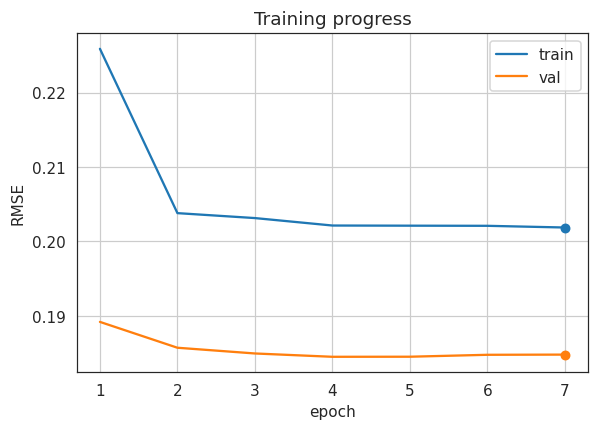

Epoch 1:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 001
TRAIN→ "R": RMSE=0.2259 MAE=0.1620 R2=-0.0110 | "B": Acc=0.8057 Prec=0.5054 Rec=0.1630 F1=0.2465 AUROC=0.7430 | "T": Acc=0.3780 Prec=0.4013 Rec=0.3780 F1=0.3854 AUROC=0.5841
VALID→ "R": RMSE=0.1892 MAE=0.1341 R2=0.2173 | "B": Acc=0.8175 Prec=0.7181 Rec=0.0379 F1=0.0719 AUROC=0.7786 | "T": Acc=0.3546 Prec=0.6687 Rec=0.3546 F1=0.3316 AUROC=0.5608


Epoch 2:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 002
TRAIN→ "R": RMSE=0.2038 MAE=0.1478 R2=0.1770 | "B": Acc=0.8140 Prec=0.5787 Rec=0.1697 F1=0.2625 AUROC=0.7688 | "T": Acc=0.3509 Prec=0.5002 Rec=0.3509 F1=0.3439 AUROC=0.5722
VALID→ "R": RMSE=0.1857 MAE=0.1339 R2=0.2458 | "B": Acc=0.8236 Prec=0.7039 Rec=0.0962 F1=0.1693 AUROC=0.7847 | "T": Acc=0.3721 Prec=0.6118 Rec=0.3721 F1=0.3725 AUROC=0.5792


Epoch 3:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 003
TRAIN→ "R": RMSE=0.2031 MAE=0.1476 R2=0.1824 | "B": Acc=0.8154 Prec=0.5818 Rec=0.1898 F1=0.2862 AUROC=0.7740 | "T": Acc=0.3542 Prec=0.5218 Rec=0.3542 F1=0.3483 AUROC=0.5704
VALID→ "R": RMSE=0.1849 MAE=0.1343 R2=0.2520 | "B": Acc=0.8257 Prec=0.6911 Rec=0.1216 F1=0.2068 AUROC=0.7861 | "T": Acc=0.3748 Prec=0.6071 Rec=0.3748 F1=0.3923 AUROC=0.5788


Epoch 4:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 004
TRAIN→ "R": RMSE=0.2021 MAE=0.1467 R2=0.1904 | "B": Acc=0.8164 Prec=0.5885 Rec=0.1945 F1=0.2923 AUROC=0.7767 | "T": Acc=0.3546 Prec=0.5094 Rec=0.3546 F1=0.3486 AUROC=0.5711
VALID→ "R": RMSE=0.1845 MAE=0.1345 R2=0.2556 | "B": Acc=0.8264 Prec=0.6859 Rec=0.1307 F1=0.2196 AUROC=0.7875 | "T": Acc=0.3730 Prec=0.6099 Rec=0.3730 F1=0.3879 AUROC=0.5801


Epoch 5:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 005
TRAIN→ "R": RMSE=0.2021 MAE=0.1463 R2=0.1906 | "B": Acc=0.8169 Prec=0.5935 Rec=0.1942 F1=0.2926 AUROC=0.7782 | "T": Acc=0.3570 Prec=0.5307 Rec=0.3570 F1=0.3519 AUROC=0.5680
VALID→ "R": RMSE=0.1845 MAE=0.1347 R2=0.2555 | "B": Acc=0.8277 Prec=0.6721 Rec=0.1513 F1=0.2470 AUROC=0.7882 | "T": Acc=0.3683 Prec=0.5977 Rec=0.3683 F1=0.3796 AUROC=0.5800


Epoch 6:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 006
TRAIN→ "R": RMSE=0.2021 MAE=0.1462 R2=0.1907 | "B": Acc=0.8173 Prec=0.5960 Rec=0.1955 F1=0.2944 AUROC=0.7791 | "T": Acc=0.3571 Prec=0.5434 Rec=0.3571 F1=0.3522 AUROC=0.5673
VALID→ "R": RMSE=0.1848 MAE=0.1349 R2=0.2534 | "B": Acc=0.8289 Prec=0.6552 Rec=0.1778 F1=0.2796 AUROC=0.7885 | "T": Acc=0.3682 Prec=0.5901 Rec=0.3682 F1=0.3795 AUROC=0.5804


Epoch 7:   0%|          | 0/119 [00:00<?, ?bundle/s]

Epoch 007
TRAIN→ "R": RMSE=0.2019 MAE=0.1458 R2=0.1925 | "B": Acc=0.8178 Prec=0.5988 Rec=0.1980 F1=0.2976 AUROC=0.7796 | "T": Acc=0.3583 Prec=0.5482 Rec=0.3583 F1=0.3538 AUROC=0.5656
VALID→ "R": RMSE=0.1848 MAE=0.1344 R2=0.2532 | "B": Acc=0.8295 Prec=0.6498 Rec=0.1900 F1=0.2940 AUROC=0.7890 | "T": Acc=0.3678 Prec=0.5856 Rec=0.3678 F1=0.3791 AUROC=0.5804
Early stopping at epoch 7

Champion validation RMSE = 0.184502
Improvement over zero‐baseline =  35.1%


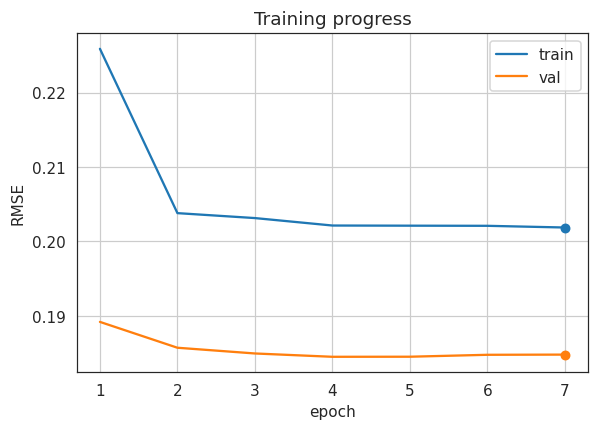

In [10]:
# -----------------------------------------------------------------------------
# Run the custom stateful training loop
# -----------------------------------------------------------------------------
best_val_rmse  = models.custom_stateful_training_loop(
    model               = model,
    optimizer           = optimizer,
    cosine_sched        = cosine_sched,
    plateau_sched       = plateau_sched,
    scaler              = scaler,
    train_loader        = train_loader,
    val_loader          = val_loader,
    max_epochs          = params.hparams['MAX_EPOCHS'],
    early_stop_patience = params.hparams['EARLY_STOP_PATIENCE'],
    baseline_val_rmse   = baseline_val_rmse,
    clipnorm            = clipnorm,
    device              = device
)

# -----------------------------------------------------------------------------
# Final reporting: best RMSE and relative improvement
# -----------------------------------------------------------------------------
print(f"\nChampion validation RMSE = {best_val_rmse:.6f}")

improvement = 100.0 * (1.0 - best_val_rmse / baseline_val_rmse)
print(f"Improvement over zero‐baseline = {improvement:5.1f}%")
